<a href="https://colab.research.google.com/github/khanc26/IS403_O22_HTCL_2/blob/week6_buidinhtrieu/Model/RNN/RNN_DHT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import the necessary libraries

In [1]:
import pandas as pd
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
%matplotlib inline

## Load data

In [2]:
data = pd.read_csv(r'C:\Users\trieu\OneDrive\Documents\HK2_2024\IS403\IS403_BA\IS403_O22_HTCL_2\Dataset\DHT Historical Data.csv')
df = data.copy()
df

,Date,Price,Open,High,Low,Vol.,Change %
0,05/31/2024,"40,400.0","39,300.0","41,000.0","38,900.0",154.53K,2.80%
1,05/30/2024,"39,300.0","38,800.0","39,800.0","38,500.0",76.57K,-0.51%
2,05/29/2024,"39,500.0","39,900.0","39,900.0","38,300.0",107.35K,0.51%
3,05/28/2024,"39,300.0","38,600.0","39,500.0","38,200.0",61.63K,1.81%
4,05/27/2024,"38,600.0","35,200.0","39,900.0","35,200.0",133.26K,6.04%
...,...,...,...,...,...,...,...
1307,03/07/2019,"11,589.7","11,842.2","11,842.2","11,224.9",240.15K,0.24%
1308,03/06/2019,"11,561.6","11,309.1","11,589.7","11,309.1",292.91K,1.98%
1309,03/05/2019,"11,337.1","11,224.9","11,365.2","10,888.1",308.00K,1.00%
1310,03/04/2019,"11,224.9","11,056.5","11,477.4","11,056.5",296.00K,3.36%


## Data preprocessing

In [3]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Sort the data by date in ascending order
df = df.sort_values('Date')

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)
df = df.replace(',', '', regex=True)
# df['Price'] = df['Price'].fillna(method='ffill')

In [4]:
# Show Dataframe
df

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2019-03-01,10860.1,10916.2,11224.9,10663.6,138.72K,1.84%
2019-03-04,11224.9,11056.5,11477.4,11056.5,296.00K,3.36%
2019-03-05,11337.1,11224.9,11365.2,10888.1,308.00K,1.00%
2019-03-06,11561.6,11309.1,11589.7,11309.1,292.91K,1.98%
2019-03-07,11589.7,11842.2,11842.2,11224.9,240.15K,0.24%
...,...,...,...,...,...,...
2024-05-27,38600.0,35200.0,39900.0,35200.0,133.26K,6.04%
2024-05-28,39300.0,38600.0,39500.0,38200.0,61.63K,1.81%
2024-05-29,39500.0,39900.0,39900.0,38300.0,107.35K,0.51%


## Scale Data

In [5]:
# Select 'Close' column
data = df['Price'].values

In [6]:
# Scale data
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(data.reshape(-1, 1))

## Model 7 : 3

In [7]:
# Define the size of train and test set
train_size = int(len(data_scaled) * 0.7)
test_size = len(data_scaled) - train_size

# Split the data into train and test sets
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:]

## Create and add data into X, y

In [8]:
# Function to prepare data for RNN
def add_data(data, sequence_length=60):
    X, Y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length), 0])
        Y.append(data[i + sequence_length, 0])
    return np.array(X), np.array(Y)

In [9]:
# Prepare sequences
sequence_length = 30
train_last_windowsize = train_data[-sequence_length:]
test_data_extended = np.concatenate((train_last_windowsize, test_data), axis=0)

X_train, y_train = add_data(train_data, sequence_length)
X_test, y_test = add_data(test_data_extended, sequence_length)

In [10]:
# Reshape data for RNN
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

## Build Model

In [11]:
# Build the RNN model
model = Sequential()
model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(SimpleRNN(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(SimpleRNN(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(SimpleRNN(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

c:\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Training Model

In [12]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)


Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.5030
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2483
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1804
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1533
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1106
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0953
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0780
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0520
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0445
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0420
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0355
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0273
Epoch 13/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0289
Epoch 14/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0215
Epoch 15/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - lo

## Predict Close price in test set

In [13]:
# Make predictions
y_pred = model.predict(X_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


## Transform data back to the original

In [14]:
# Inverse transform the predictions and actual values
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
train_data = scaler.inverse_transform(train_data)
test_data = scaler.inverse_transform(test_data)

## Calculate the error of the model

In [15]:
# Calculate error metrics
test_mape = mean_absolute_percentage_error(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_msle = mean_squared_log_error(y_test, y_pred)

print(f"MAPE on Test set: {test_mape}")
print(f"RMSE on Test set: {test_rmse}")
print(f"MSLE on Test set: {test_msle}")

MAPE on Test set: 0.04125843660204718
RMSE on Test set: 1675.0958523660017
MSLE on Test set: 0.0037326425624483986


## Predict Close price for 30 next days

In [16]:
# Predict next 30, 60, and 90 days
last_sequence_days = data_scaled[-sequence_length:].reshape(1, sequence_length, 1)
y_next_30_days = []
y_next_60_days = []
y_next_90_days = []

for i in range(90):
    next_day_pred = model.predict(last_sequence_days)
    if i < 30:
        y_next_30_days.append(next_day_pred[0][0])
    if i < 60:
        y_next_60_days.append(next_day_pred[0][0])
    y_next_90_days.append(next_day_pred[0][0])
    last_sequence_days = np.concatenate([last_sequence_days[:, 1:, :], next_day_pred.reshape(1, 1, 1)], axis=1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━

In [17]:
# Inverse transform the predictions
y_next_30_days = scaler.inverse_transform(np.array(y_next_30_days).reshape(-1, 1)).flatten()
y_next_60_days = scaler.inverse_transform(np.array(y_next_60_days).reshape(-1, 1)).flatten()
y_next_90_days = scaler.inverse_transform(np.array(y_next_90_days).reshape(-1, 1)).flatten()

In [18]:
# Print the predicted values
print("Predicted next 30 days:")
print(y_next_30_days)
print("\nPredicted next 60 days:")
print(y_next_60_days)
print("\nPredicted next 90 days:")
print(y_next_90_days)

Predicted next 30 days:
[33800.91  33491.535 32011.072 30846.037 29501.877 28662.898 27885.557
 27570.873 27296.498 26578.344 26453.91  26287.184 25818.324 25460.85
 25159.576 24583.648 24514.441 24087.61  23667.639 23610.1   23621.938
 23464.719 23294.422 23238.527 23234.684 23125.752 23002.586 22963.27
 23069.314 22983.318]

Predicted next 60 days:
[33800.91  33491.535 32011.072 30846.037 29501.877 28662.898 27885.557
 27570.873 27296.498 26578.344 26453.91  26287.184 25818.324 25460.85
 25159.576 24583.648 24514.441 24087.61  23667.639 23610.1   23621.938
 23464.719 23294.422 23238.527 23234.684 23125.752 23002.586 22963.27
 23069.314 22983.318 22734.406 22698.227 22595.176 22489.246 22359.828
 22250.137 22146.861 22071.664 21970.955 21859.006 21777.912 21697.912
 21602.799 21514.26  21407.213 21312.186 21235.373 21109.016 20998.951
 20926.006 20849.771 20751.576 20664.799 20599.832 20535.879 20458.277
 20381.314 20320.748 20270.602 20200.398]

Predicted next 90 days:
[33800.91  334

## Model visualization

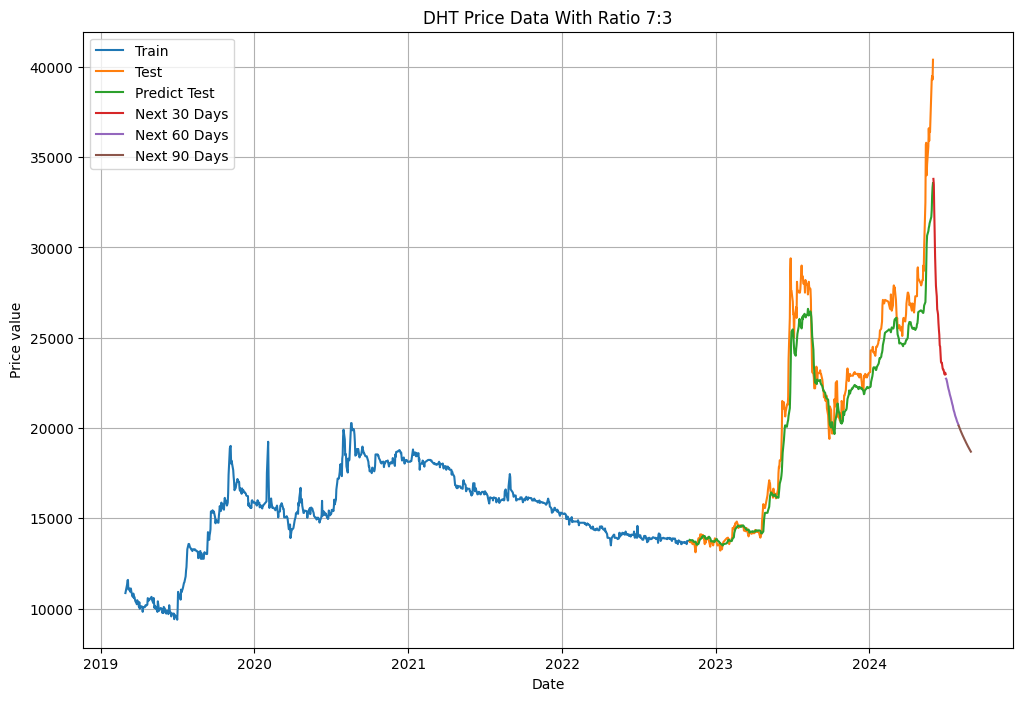

In [19]:
# Create DataFrames for plotting
train_data_df = pd.DataFrame(train_data, index=df.index[:train_size], columns=['Price'])
test_data_df = pd.DataFrame(test_data, index=df.index[train_size:], columns=['Price'])
y_pred_df = pd.DataFrame(y_pred, index=df.index[train_size:], columns=['Predict Test'])
next_30_days_df = pd.DataFrame(y_next_30_days, index=pd.date_range(start=df.index[-1] + pd.DateOffset(days=1), periods=30), columns=['Next 30 Days'])
next_60_days_df = pd.DataFrame(y_next_60_days[30:], index=pd.date_range(start=df.index[-1] + pd.DateOffset(days=31), periods=30), columns=['Next 60 Days'])
next_90_days_df = pd.DataFrame(y_next_90_days[60:], index=pd.date_range(start=df.index[-1] + pd.DateOffset(days=61), periods=30), columns=['Next 90 Days'])
# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(train_data_df.index, train_data_df['Price'], label='Train')
plt.plot(test_data_df.index, test_data_df['Price'], label='Test')
plt.plot(y_pred_df.index, y_pred_df['Predict Test'], label='Predict Test')
plt.plot(next_30_days_df.index, next_30_days_df['Next 30 Days'], label='Next 30 Days')
plt.plot(next_60_days_df.index, next_60_days_df['Next 60 Days'], label='Next 60 Days')
plt.plot(next_90_days_df.index, next_90_days_df['Next 90 Days'], label='Next 90 Days')
plt.legend()
plt.grid()
plt.title("DHT Price Data With Ratio 7:3")
plt.xlabel("Date")
plt.ylabel("Price value")
plt.savefig('RNN_73_DHT.png')
plt.show()

## Model 8 : 2

In [20]:
data = pd.read_csv(r'C:\Users\trieu\OneDrive\Documents\HK2_2024\IS403\IS403_BA\IS403_O22_HTCL_2\Dataset\DHT Historical Data.csv')
df = data.copy()
df

,Date,Price,Open,High,Low,Vol.,Change %
0,05/31/2024,"40,400.0","39,300.0","41,000.0","38,900.0",154.53K,2.80%
1,05/30/2024,"39,300.0","38,800.0","39,800.0","38,500.0",76.57K,-0.51%
2,05/29/2024,"39,500.0","39,900.0","39,900.0","38,300.0",107.35K,0.51%
3,05/28/2024,"39,300.0","38,600.0","39,500.0","38,200.0",61.63K,1.81%
4,05/27/2024,"38,600.0","35,200.0","39,900.0","35,200.0",133.26K,6.04%
...,...,...,...,...,...,...,...
1307,03/07/2019,"11,589.7","11,842.2","11,842.2","11,224.9",240.15K,0.24%
1308,03/06/2019,"11,561.6","11,309.1","11,589.7","11,309.1",292.91K,1.98%
1309,03/05/2019,"11,337.1","11,224.9","11,365.2","10,888.1",308.00K,1.00%
1310,03/04/2019,"11,224.9","11,056.5","11,477.4","11,056.5",296.00K,3.36%


In [21]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Sort the data by date in ascending order
df = df.sort_values('Date')

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)
df = df.replace(',', '', regex=True)

In [22]:
# Select 'Close' column
data = df['Price'].values

In [23]:
# Scale data
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(data.reshape(-1, 1))

In [24]:
# Define the size of train and test set
train_size = int(len(data_scaled) * 0.8)
test_size = len(data_scaled) - train_size

# Split the data into train and test sets
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:]

In [25]:
# Function to prepare data for RNN
def add_data(data, sequence_length=30):
    X, Y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length), 0])
        Y.append(data[i + sequence_length, 0])
    return np.array(X), np.array(Y)

In [26]:
# Prepare sequences
sequence_length = 30
train_last_windowsize = train_data[-sequence_length:]
test_data_extended = np.concatenate((train_last_windowsize, test_data), axis=0)

X_train, y_train = add_data(train_data, sequence_length)
X_test, y_test = add_data(test_data_extended, sequence_length)

In [27]:
# Reshape data for RNN
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [28]:
# Build the RNN model
model = Sequential()
model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(SimpleRNN(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(SimpleRNN(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(SimpleRNN(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

c:\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [29]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.5802
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3413
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2592
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1711
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1690
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1372
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0930
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0837
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0666
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0608
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0475
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0453
Epoch 13/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0443
Epoch 14/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0341
Epoch 15/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - lo

In [30]:
# Make predictions
y_pred = model.predict(X_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


In [31]:
# Inverse transform the predictions and actual values
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
train_data = scaler.inverse_transform(train_data)
test_data = scaler.inverse_transform(test_data)

In [32]:
# Calculate error metrics
test_mape = mean_absolute_percentage_error(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_msle = mean_squared_log_error(y_test, y_pred)

print(f"MAPE on Test set: {test_mape}")
print(f"RMSE on Test set: {test_rmse}")
print(f"MSLE on Test set: {test_msle}")

MAPE on Test set: 0.07005141870519453
RMSE on Test set: 2503.9468635747876
MSLE on Test set: 0.008178694372802017


In [33]:
# Predict next 30, 60, and 90 days
last_sequence_days = data_scaled[-sequence_length:].reshape(1, sequence_length, 1)
y_next_30_days = []
y_next_60_days = []
y_next_90_days = []

for i in range(90):
    next_day_pred = model.predict(last_sequence_days)
    if i < 30:
        y_next_30_days.append(next_day_pred[0][0])
    if i < 60:
        y_next_60_days.append(next_day_pred[0][0])
    y_next_90_days.append(next_day_pred[0][0])
    last_sequence_days = np.concatenate([last_sequence_days[:, 1:, :], next_day_pred.reshape(1, 1, 1)], axis=1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

In [34]:
# Inverse transform the predictions
y_next_30_days = scaler.inverse_transform(np.array(y_next_30_days).reshape(-1, 1)).flatten()
y_next_60_days = scaler.inverse_transform(np.array(y_next_60_days).reshape(-1, 1)).flatten()
y_next_90_days = scaler.inverse_transform(np.array(y_next_90_days).reshape(-1, 1)).flatten()

In [35]:
# Print the predicted values
print("Predicted next 30 days:")
print(y_next_30_days)
print("\nPredicted next 60 days:")
print(y_next_60_days)
print("\nPredicted next 90 days:")
print(y_next_90_days)

Predicted next 30 days:
[31852.258 31134.54  29163.791 27325.219 26304.312 25168.154 24382.508
 23435.232 22668.027 22470.31  22433.832 21352.836 21118.088 20715.998
 20262.54  20248.145 20530.41  20224.809 20243.393 19951.578 19920.162
 20075.139 19989.885 20198.174 19987.191 20109.498 20115.047 20270.121
 20210.807 20518.027]

Predicted next 60 days:
[31852.258 31134.54  29163.791 27325.219 26304.312 25168.154 24382.508
 23435.232 22668.027 22470.31  22433.832 21352.836 21118.088 20715.998
 20262.54  20248.145 20530.41  20224.809 20243.393 19951.578 19920.162
 20075.139 19989.885 20198.174 19987.191 20109.498 20115.047 20270.121
 20210.807 20518.027 20190.885 20194.75  20108.994 20013.604 19991.283
 19901.307 19812.383 19712.674 19586.25  19485.846 19507.19  19320.66
 19266.598 19143.217 19023.857 18925.236 18892.727 18777.404 18728.432
 18614.805 18524.664 18481.936 18382.473 18361.879 18274.098 18221.842
 18152.283 18123.629 18049.682 18050.799]

Predicted next 90 days:
[31852.258 

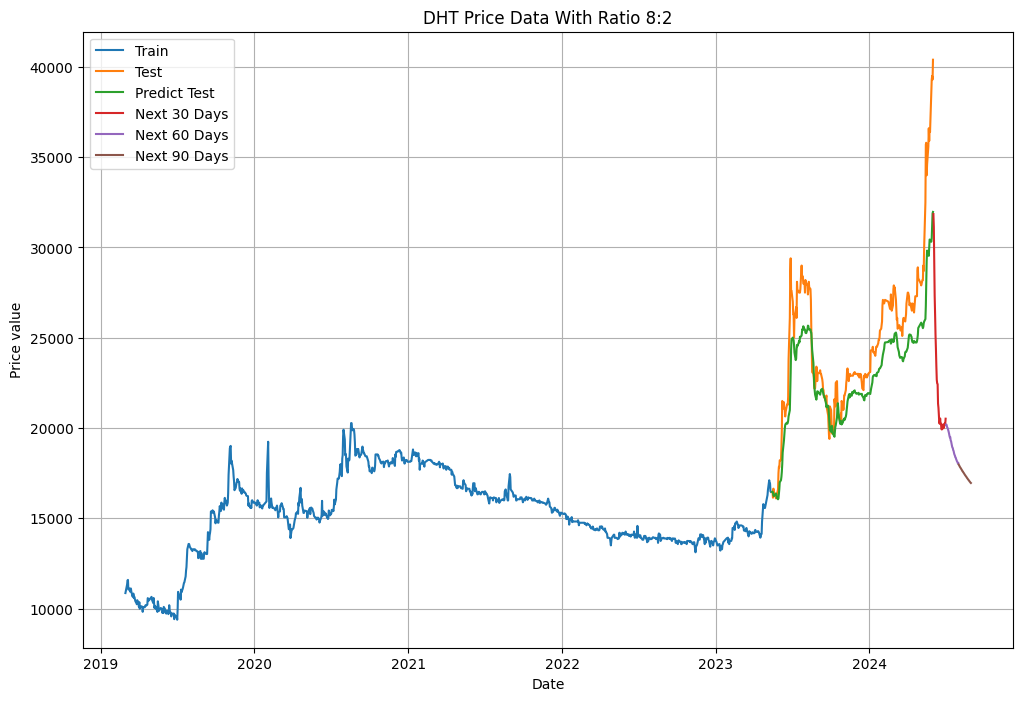

In [36]:
# Create DataFrames for plotting
train_data_df = pd.DataFrame(train_data, index=df.index[:train_size], columns=['Price'])
test_data_df = pd.DataFrame(test_data, index=df.index[train_size:], columns=['Price'])
y_pred_df = pd.DataFrame(y_pred, index=df.index[train_size:], columns=['Predict Test'])
next_30_days_df = pd.DataFrame(y_next_30_days, index=pd.date_range(start=df.index[-1] + pd.DateOffset(days=1), periods=30), columns=['Next 30 Days'])
next_60_days_df = pd.DataFrame(y_next_60_days[30:], index=pd.date_range(start=df.index[-1] + pd.DateOffset(days=31), periods=30), columns=['Next 60 Days'])
next_90_days_df = pd.DataFrame(y_next_90_days[60:], index=pd.date_range(start=df.index[-1] + pd.DateOffset(days=61), periods=30), columns=['Next 90 Days'])
# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(train_data_df.index, train_data_df['Price'], label='Train')
plt.plot(test_data_df.index, test_data_df['Price'], label='Test')
plt.plot(y_pred_df.index, y_pred_df['Predict Test'], label='Predict Test')
plt.plot(next_30_days_df.index, next_30_days_df['Next 30 Days'], label='Next 30 Days')
plt.plot(next_60_days_df.index, next_60_days_df['Next 60 Days'], label='Next 60 Days')
plt.plot(next_90_days_df.index, next_90_days_df['Next 90 Days'], label='Next 90 Days')
plt.legend()
plt.grid()
plt.title("DHT Price Data With Ratio 8:2")
plt.xlabel("Date")
plt.ylabel("Price value")
plt.savefig('RNN_82_DHT.png')
plt.show()

## Model 9 : 1

In [37]:
data = pd.read_csv(r'C:\Users\trieu\OneDrive\Documents\HK2_2024\IS403\IS403_BA\IS403_O22_HTCL_2\Dataset\DHT Historical Data.csv')
df = data.copy()
df

,Date,Price,Open,High,Low,Vol.,Change %
0,05/31/2024,"40,400.0","39,300.0","41,000.0","38,900.0",154.53K,2.80%
1,05/30/2024,"39,300.0","38,800.0","39,800.0","38,500.0",76.57K,-0.51%
2,05/29/2024,"39,500.0","39,900.0","39,900.0","38,300.0",107.35K,0.51%
3,05/28/2024,"39,300.0","38,600.0","39,500.0","38,200.0",61.63K,1.81%
4,05/27/2024,"38,600.0","35,200.0","39,900.0","35,200.0",133.26K,6.04%
...,...,...,...,...,...,...,...
1307,03/07/2019,"11,589.7","11,842.2","11,842.2","11,224.9",240.15K,0.24%
1308,03/06/2019,"11,561.6","11,309.1","11,589.7","11,309.1",292.91K,1.98%
1309,03/05/2019,"11,337.1","11,224.9","11,365.2","10,888.1",308.00K,1.00%
1310,03/04/2019,"11,224.9","11,056.5","11,477.4","11,056.5",296.00K,3.36%


In [38]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Sort the data by date in ascending order
df = df.sort_values('Date')

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)
df = df.replace(',', '', regex=True)

In [39]:
# Select 'Close' column
data = df['Price'].values

In [40]:
# Scale data
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(data.reshape(-1, 1))

In [41]:
# Define the size of train and test set
train_size = int(len(data_scaled) * 0.9)
test_size = len(data_scaled) - train_size

# Split the data into train and test sets
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:]

In [42]:
# Function to prepare data for RNN
def add_data(data, sequence_length=60):
    X, Y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length), 0])
        Y.append(data[i + sequence_length, 0])
    return np.array(X), np.array(Y)

In [43]:
# Prepare sequences
sequence_length = 30
train_last_windowsize = train_data[-sequence_length:]
test_data_extended = np.concatenate((train_last_windowsize, test_data), axis=0)

X_train, y_train = add_data(train_data, sequence_length)
X_test, y_test = add_data(test_data_extended, sequence_length)

In [44]:
# Reshape data for RNN
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [45]:
# Build the RNN model
model = Sequential()
model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(SimpleRNN(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(SimpleRNN(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(SimpleRNN(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

c:\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [46]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.4934
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.2958
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.2107
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.1743
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.1327
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0938
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0828
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0741
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0607
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0474
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0423
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0385
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0364
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0343
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - lo

In [47]:
# Make predictions
y_pred = model.predict(X_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step


In [48]:
# Inverse transform the predictions and actual values
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
train_data = scaler.inverse_transform(train_data)
test_data = scaler.inverse_transform(test_data)

In [49]:
# Calculate error metrics
test_mape = mean_absolute_percentage_error(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_msle = mean_squared_log_error(y_test, y_pred)

print(f"MAPE on Test set: {test_mape}")
print(f"RMSE on Test set: {test_rmse}")
print(f"MSLE on Test set: {test_msle}")

MAPE on Test set: 0.027527511931428682
RMSE on Test set: 1499.1119665628562
MSLE on Test set: 0.0021159253760914512


In [50]:
# Predict next 30, 60, and 90 days
last_sequence_days = data_scaled[-sequence_length:].reshape(1, sequence_length, 1)
y_next_30_days = []
y_next_60_days = []
y_next_90_days = []

for i in range(90):
    next_day_pred = model.predict(last_sequence_days)
    if i < 30:
        y_next_30_days.append(next_day_pred[0][0])
    if i < 60:
        y_next_60_days.append(next_day_pred[0][0])
    y_next_90_days.append(next_day_pred[0][0])
    last_sequence_days = np.concatenate([last_sequence_days[:, 1:, :], next_day_pred.reshape(1, 1, 1)], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━

In [51]:
# Inverse transform the predictions
y_next_30_days = scaler.inverse_transform(np.array(y_next_30_days).reshape(-1, 1)).flatten()
y_next_60_days = scaler.inverse_transform(np.array(y_next_60_days).reshape(-1, 1)).flatten()
y_next_90_days = scaler.inverse_transform(np.array(y_next_90_days).reshape(-1, 1)).flatten()

In [52]:
# Print the predicted values
print("Predicted next 30 days:")
print(y_next_30_days)
print("\nPredicted next 60 days:")
print(y_next_60_days)
print("\nPredicted next 90 days:")
print(y_next_90_days)

Predicted next 30 days:
[36368.03  36122.957 35071.3   34605.43  33687.266 33052.22  32344.992
 32018.996 31562.154 31577.031 31066.98  30903.049 30347.57  30035.535
 29618.045 29382.725 28923.588 28675.852 28296.916 28047.139 27693.883
 27500.998 27240.79  27001.959 26724.064 26503.41  26222.32  26041.055
 25859.031 25613.502]

Predicted next 60 days:
[36368.03  36122.957 35071.3   34605.43  33687.266 33052.22  32344.992
 32018.996 31562.154 31577.031 31066.98  30903.049 30347.57  30035.535
 29618.045 29382.725 28923.588 28675.852 28296.916 28047.139 27693.883
 27500.998 27240.79  27001.959 26724.064 26503.41  26222.32  26041.055
 25859.031 25613.502 25496.986 25326.86  25186.78  25059.463 24932.096
 24827.83  24707.041 24602.793 24499.393 24394.799 24308.8   24220.133
 24138.664 24065.543 23994.768 23929.154 23873.125 23815.336 23766.12
 23715.06  23671.883 23628.824 23589.7   23553.262 23522.06  23489.033
 23464.068 23437.148 23413.393 23393.623]

Predicted next 90 days:
[36368.03  

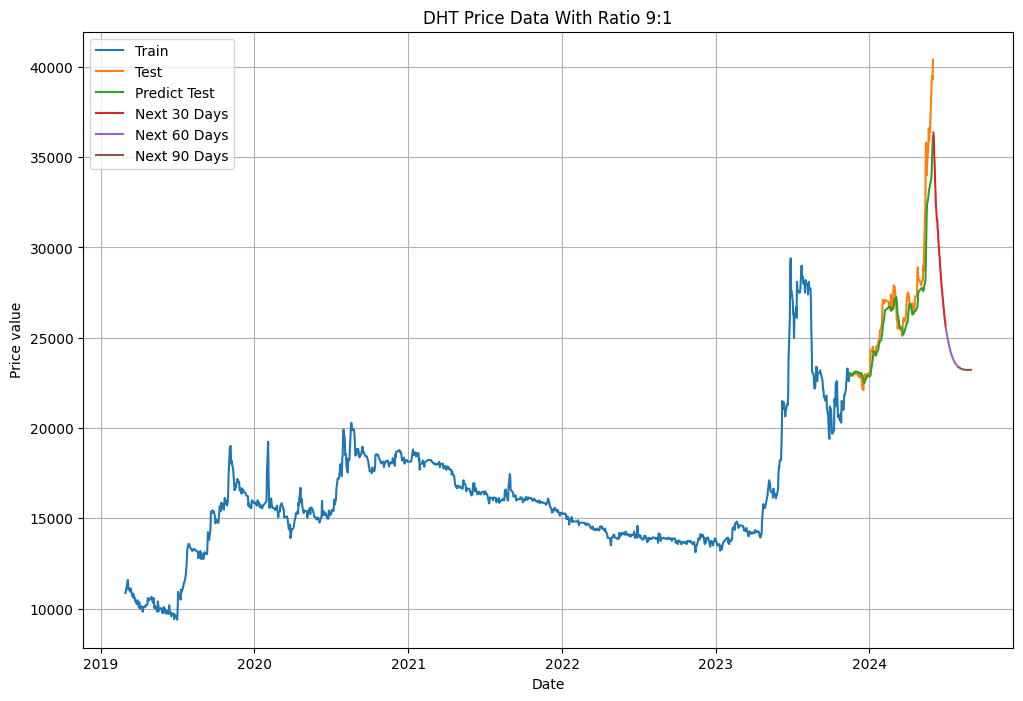

In [53]:
# Create DataFrames for plotting
train_data_df = pd.DataFrame(train_data, index=df.index[:train_size], columns=['Price'])
test_data_df = pd.DataFrame(test_data, index=df.index[train_size:], columns=['Price'])
y_pred_df = pd.DataFrame(y_pred, index=df.index[train_size:], columns=['Predict Test'])
next_30_days_df = pd.DataFrame(y_next_30_days, index=pd.date_range(start=df.index[-1] + pd.DateOffset(days=1), periods=30), columns=['Next 30 Days'])
next_60_days_df = pd.DataFrame(y_next_60_days[30:], index=pd.date_range(start=df.index[-1] + pd.DateOffset(days=31), periods=30), columns=['Next 60 Days'])
next_90_days_df = pd.DataFrame(y_next_90_days[60:], index=pd.date_range(start=df.index[-1] + pd.DateOffset(days=61), periods=30), columns=['Next 90 Days'])
# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(train_data_df.index, train_data_df['Price'], label='Train')
plt.plot(test_data_df.index, test_data_df['Price'], label='Test')
plt.plot(y_pred_df.index, y_pred_df['Predict Test'], label='Predict Test')
plt.plot(next_30_days_df.index, next_30_days_df['Next 30 Days'], label='Next 30 Days')
plt.plot(next_60_days_df.index, next_60_days_df['Next 60 Days'], label='Next 60 Days')
plt.plot(next_90_days_df.index, next_90_days_df['Next 90 Days'], label='Next 90 Days')
plt.legend()
plt.grid()
plt.title("DHT Price Data With Ratio 9:1")
plt.xlabel("Date")
plt.ylabel("Price value")
plt.savefig('RNN_91_DHT.png')
plt.show()